# Drive Test Tag Generation
Generate tags for the written portion of the chinese driving exam using a process similar to BERTopic.

## 1. Load Data
Loading data from a local database into a question bank class.

In [2]:
from src.qb.question_bank import QuestionBank
from data_storage.database.json_database import LocalJsonDB

db = LocalJsonDB("data_storage/database/json_db/data.json",
                 "data_storage/database/json_db/images")
qb : QuestionBank = db.load()
print(qb.question_count())

2836


## 2. Format Data
Although the Siglip2 model can handle images of different sizes, we will still standardize the image sizes to the same size to avoid unnecessary complications.

In [3]:
from data_cleaning.img_reshaper import ImgSquarer

IMG_DIR_256 = "data_cleaning/resized_imgs/img256"
IMG_DIR_512 = "data_cleaning/resized_imgs/img512"

squarer_256 = ImgSquarer(256)
# squarer_512 = ImgSquarer(512)

In [4]:
def resize_images(qb: QuestionBank, squarer: ImgSquarer, new_dir: str) -> None:
    for chapter_id in qb.get_all_chapter_num():
        for qid in qb.get_qids_by_chapter(chapter_id):
            question = qb.get_question(qid)
            if question.get_img_path() is not None:
                question.set_img_path(squarer.reshape(qid, qb.get_img_dir(), new_dir))

In [5]:
import os
# If the directory is empty, resize images.
if not os.listdir(IMG_DIR_256):
    print("Resizing images to 256x256...")
    resize_images(qb, squarer_256, IMG_DIR_256)
else:
    print("Images already resized to 256x256, skipping...")

Images already resized to 256x256, skipping...


## 3. Create Multimodal Embeddings
Create multimodal embeddings for the questions using a Siglip2 model.

In [6]:
# Library Imports
from transformers import AutoModel, AutoProcessor

# Local Imports
from embedder.siglip2_qb_embedder import Siglip2QBEmbedder

### a) Load/Download the Siglip2 Model
We will be using "google/siglip2-base-patch16-256" for this task.

In [7]:
import torch
MODEL_NAME = "google/siglip2-base-patch16-256"

model = AutoModel.from_pretrained(MODEL_NAME, torch_dtype=torch.float32, attn_implementation="sdpa")
processor = AutoProcessor.from_pretrained(MODEL_NAME, use_fast=True) # Ensure the model is on the correct device

### b) Create embeddings

#### i) Define a logger

In [8]:
import logging
from logging import Logger
from datetime import datetime
import os

LOGGING_PATH = "logs"

def get_logger(name: str) -> Logger:
    # Create logger
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO) # Set the logging level

    # Create a file handler with timestamp in filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    file_handler = logging.FileHandler(
        os.path.join(LOGGING_PATH, f"{name}_{timestamp}.log")
    )

    # Create formatter
    formatter = logging.Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )
    file_handler.setFormatter(formatter)

    # Add handler to logger
    logger.addHandler(file_handler)

    return logger

embedder_logger = get_logger("embedder")

#### ii) Create the embedder

In [9]:
custom_embedder = Siglip2QBEmbedder(model, processor, embedder_logger)

#### iii) Generate embeddings

In [10]:
EMBEDDINGS_DIR = "data_storage/embedding_dir"
EMBEDDING_FILE_NAME = "siglip2_embeddings.npz"

os.makedirs(EMBEDDINGS_DIR, exist_ok=True)
embedding_file = os.path.join(EMBEDDINGS_DIR, EMBEDDING_FILE_NAME)
print(embedding_file)

data_storage/embedding_dir/siglip2_embeddings.npz


In [11]:
if EMBEDDING_FILE_NAME in os.listdir(EMBEDDINGS_DIR):
    print(f"Embeddings already exist at {embedding_file}, skipping generation.")
else:
    print("Generating embeddings...")
    # Generate embeddings for the question bank
    embeddings = custom_embedder.encode_qb(qb)

Generating embeddings...


#### iv) Save embeddings

In [12]:
import numpy as np

def save_embeddings(embeddings, file_path):
    np.savez(file_path, **{str(qid): embeddings[qid] for qid in embeddings})

if not os.path.exists(embedding_file):
    print(f"Saving embeddings to {embedding_file}...")
    save_embeddings(embeddings, embedding_file)
else:
    print(f"Embeddings file {embedding_file} already exists, skipping save.")

Saving embeddings to data_storage/embedding_dir/siglip2_embeddings.npz...


## 4. Dimension Reduction

### a) Load Embeddings

In [13]:
# To load the embeddings later:
def load_embeddings(file_path):
    loaded = np.load(file_path)
    return {key: loaded[key] for key in loaded.files}
id_to_embedding = load_embeddings(embedding_file)

In [14]:
from typing import List

from embedder.siglip2_qb_embedder import format_question

def format_for_clustering(id_to_embedding: dict, qb: QuestionBank) -> (List[str], List[str], np.ndarray):
    """
    Format the embeddings for clustering.
    """
    qid_lst = []
    documents: List[str] = []
    embedding_lst: List[np.ndarray] = []
    for chapter_id in qb.get_all_chapter_num():
        for qid in qb.get_qids_by_chapter(chapter_id):
            doc = format_question(qb.get_question(qid), qb.describe_chapter(chapter_id))
            qid_lst.append(qid)
            documents.append(doc)
            embedding_lst.append(id_to_embedding[qid])
    embedding_array = np.array(embedding_lst)
    return qid_lst, documents, embedding_array

In [15]:
qid_lst, documents, embeds = format_for_clustering(id_to_embedding, qb)
print(f"Number of questions: {len(qid_lst)} "
      f"Embedding shape: {embeds.shape}")

Number of questions: 2836 Embedding shape: (2836, 768)


In [16]:
documents[:5]  # Display the first 5 documents to verify formatting

['题目:机动车未达到国家强制报废标准，机动车所有人自愿报废的，应当向什么地方的车辆管理所提出申请？答案:登记地',
 '题目:如图所示，驾驶机动车遇到这种情况，以下做法正确的是什么？答案:降低行驶速度，避让行人',
 '题目:饮用少量啤酒不影响驾驶操作可以短距离驾驶机动车。答案:错',
 '题目:从事校车业务或者旅客运输，严重超过额定乘员载客的，可构成危险驾驶罪。答案:对',
 '题目:以下哪个代号表示准驾中型载货汽车？答案:B2']

### b) Set up dimension reduction model
We will be using UMAP for dimension reduction.

In [17]:
from umap import UMAP
def dim_reduction(dimensions: int, n_neighbors: int) -> np.ndarray:
    umap_model = UMAP(
        n_components=dimensions,
        metric='cosine',
        n_neighbors=n_neighbors,
        min_dist=0.0
    )
    return umap_model.fit_transform(embeds)

### c) Experiment with different parameters
Using dimension 2, experiment with different values of `n_neighbors` to see how it affects the clustering.

In [18]:
def save_rdc_embeddings(embeddings, file_path):
    np.savez(file_path, embeddings=embeddings)

In [19]:
def load_rdc_embeddings(file_path):
    loaded = np.load(file_path)
    return loaded['embeddings']

In [31]:
from typing import Dict

def make_test_embeds() -> Dict[int, np.ndarray]:
    n_to_embed = {}
    for n in range(4, 27, 4):
        file_name = f"data_storage/embedding_dir/2d_rdc_embeds_n{n}.npz"
        if not os.path.exists(file_name):
            print(f"Reducing dimensions with n_neighbors={n}...")
            rdc_embeds = dim_reduction(2, n)
            n_to_embed[n] = rdc_embeds
            print(f"Saving reduced dimension embeddings to {file_name}...")
            save_rdc_embeddings(rdc_embeds, file_name)
        else:
            print(f"Reduced dimension embeddings file {file_name} already exists. Loading embedding.")
            n_to_embed[n] = load_rdc_embeddings(file_name)
    return n_to_embed

Visualize the embeddings using seaborn

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_2d_embeds(embeds_2d, title=None):
    """
    Plot a single 2D embedding using seaborn.

    Args:
        embeds_2d: 2D embeddings array with shape (n_samples, 2)
        title: Optional title for the plot

    Returns:
        The scatter plot object
    """
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x=embeds_2d[:, 0],
        y=embeds_2d[:, 1],
        alpha=0.7,
        s=40  # Point size
    )
    if title:
        plt.title(title, fontsize=15)
    else:
        plt.title('2D Embedding Visualization', fontsize=15)
    plt.xlabel('UMAP Dimension 1', fontsize=12)
    plt.ylabel('UMAP Dimension 2', fontsize=12)
    plt.grid(alpha=0.3)

    # Remove top and right borders
    sns.despine()

    plt.tight_layout()
    return scatter

def plot_multiple_2d_embeds(n_to_embeds):
    """
    Plot multiple 2D embeddings with different n_neighbors values.

    Args:
        n_to_embeds: Dictionary mapping n_neighbors values to 2D embeddings

    Returns:
        The matplotlib figure containing all subplots
    """
    # Calculate grid dimensions based on number of embeddings
    n_plots = len(n_to_embeds)
    n_cols = min(3, n_plots)  # Maximum 3 columns
    n_rows = math.ceil(n_plots / n_cols)

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))

    # Flatten axes if it's a 2D array
    if n_plots > 1:
        if n_rows > 1 and n_cols > 1:
            axes = axes.flatten()
        elif n_rows == 1:
            axes = [axes[i] for i in range(n_cols)]
        elif n_cols == 1:
            axes = [axes[i] for i in range(n_rows)]
    else:
        axes = [axes]

    # Sort n values for consistent visualization
    sorted_n_values = sorted(n_to_embeds.keys())

    # Plot each embedding
    for i, n in enumerate(sorted_n_values):
        embeds = n_to_embeds[n]
        ax = axes[i]

        sns.scatterplot(
            x=embeds[:, 0],
            y=embeds[:, 1],
            alpha=0.7,
            s=30,
            ax=ax
        )

        ax.set_title(f'n_neighbors = {n}', fontsize=14)
        ax.set_xlabel('UMAP Dimension 1', fontsize=12)
        ax.set_ylabel('UMAP Dimension 2', fontsize=12)
        ax.grid(alpha=0.3)
        sns.despine(ax=ax)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    return fig

Reducing dimensions with n_neighbors=4...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving reduced dimension embeddings to data_storage/embedding_dir/2d_rdc_embeds_n4.npz...
Reducing dimensions with n_neighbors=8...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving reduced dimension embeddings to data_storage/embedding_dir/2d_rdc_embeds_n8.npz...
Reducing dimensions with n_neighbors=12...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving reduced dimension embeddings to data_storage/embedding_dir/2d_rdc_embeds_n12.npz...
Reducing dimensions with n_neighbors=16...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving reduced dimension embeddings to data_storage/embedding_dir/2d_rdc_embeds_n16.npz...
Reduced dimension embeddings file data_storage/embedding_dir/2d_rdc_embeds_n20.npz already exists. Loading embedding.
Reducing dimensions with n_neighbors=24...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving reduced dimension embeddings to data_storage/embedding_dir/2d_rdc_embeds_n24.npz...


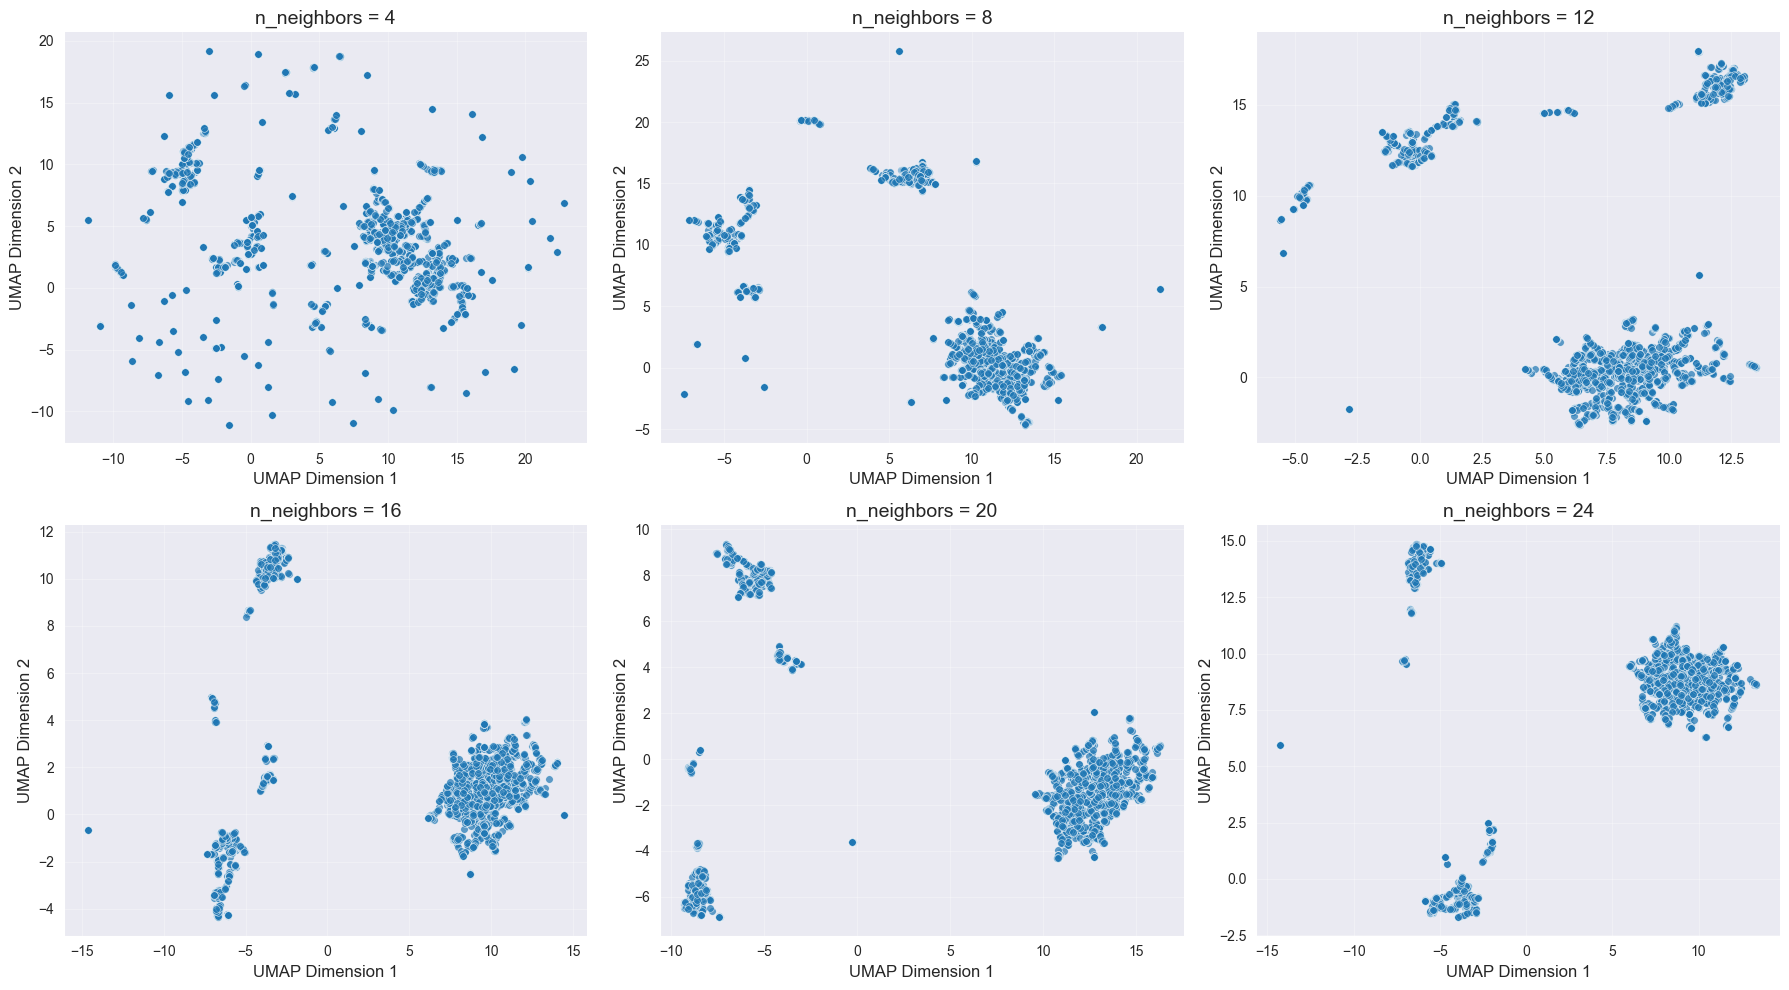

In [33]:
EXPERIMENT_N_NEIGHBORS = True
if EXPERIMENT_N_NEIGHBORS:
    # Visualize the embeddings for different n_neighbors values
    n_to_embeds = make_test_embeds()
    fig = plot_multiple_2d_embeds(n_to_embeds)
    plt.show()

### d) Using an n_neighbors value, create high dimensional embeddings
...

In [56]:
n_neighbors = 10
dim = 512
rdc_embeds_path = f"data_storage/embedding_dir/rdc_embeds_n{n_neighbors}d{dim}.npz"
if not os.path.exists(rdc_embeds_path):
    print(f"Reducing dimensions to {dim} with n_neighbors={n_neighbors}...")
    rdc_embeds = dim_reduction(dim, n_neighbors)
    print(f"Saving reduced dimension embeddings to {rdc_embeds_path}...")
    save_rdc_embeddings(rdc_embeds, rdc_embeds_path)
else:
    print(f"Reduced dimension embeddings file {rdc_embeds_path} already exists. Loading embedding.")
    rdc_embeds = load_rdc_embeddings(rdc_embeds_path)
print(f"Embeddings successfully loaded. Shape: {rdc_embeds.shape}")

Reducing dimensions to 512 with n_neighbors=10...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving reduced dimension embeddings to data_storage/embedding_dir/rdc_embeds_n10d512.npz...
Embeddings successfully loaded. Shape: (2836, 512)


## 5. Clustering


Generate a small representative sample of the question bank by clustering the questions and selecting representative questions from each cluster.

In [87]:
from sklearn.cluster import HDBSCAN
def cluster_embeddings(embeddings: np.ndarray) -> np.ndarray:
    """
    Cluster the embeddings using HDBSCAN.

    Args:
        embeddings: Embeddings array with shape (n_samples, n_features)

    Returns:
        Cluster labels for each embedding
    """
    clusterer = HDBSCAN(min_cluster_size=2, metric='cosine', min_samples=1, cluster_selection_method="leaf", allow_single_cluster=True)
    cluster_labels = clusterer.fit_predict(embeddings)
    return cluster_labels

In [88]:
cluster_labels = cluster_embeddings(rdc_embeds)

In [89]:
from pandas import DataFrame

topic_df = DataFrame({"topic": cluster_labels, "id": qid_lst, "document": documents})
topic_df.head()

,topic,id,document
0,265,c3471,题目:机动车未达到国家强制报废标准，机动车所有人自愿报废的，应当向什么地方的车辆管理所提出申...
1,302,79e7e,题目:如图所示，驾驶机动车遇到这种情况，以下做法正确的是什么？答案:降低行驶速度，避让行人
2,-1,fe7bc,题目:饮用少量啤酒不影响驾驶操作可以短距离驾驶机动车。答案:错
3,500,f21d6,题目:从事校车业务或者旅客运输，严重超过额定乘员载客的，可构成危险驾驶罪。答案:对
4,590,a1847,题目:以下哪个代号表示准驾中型载货汽车？答案:B2


In [90]:
topic_df_sorted = topic_df.sort_values("topic", ascending=True)[topic_df["topic"] > -1]
topic_df_sorted.head(100)

/var/folders/71/jllnlvwn0gv1k0610m4_0dvh0000gn/T/ipykernel_6814/1791603532.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  topic_df_sorted = topic_df.sort_values("topic", ascending=True)[topic_df["topic"] > -1]


,topic,id,document
2549,0,db847,题目:这个标志是何含义？答案:禁止鸣喇叭
1507,0,a8ac2,题目:这个标志是何含义？答案:禁止鸣喇叭
977,1,d2822,题目:这个标志的含义是提醒驾驶人注意前方路段积水。答案:对
798,1,b7e92,题目:这个标志表示禁止车货总体外廓高度超过标志所示数值的车辆通行。答案:错
1349,1,cbd24,题目:这个标志是何含义？答案:注意积水
...,...,...,...
1783,32,a78fb,题目:这个标志是何含义？答案:隧道开灯
921,32,fdb07,题目:这个标志的含义是提醒车辆驾驶人前方是单向行驶并且照明不好的涵洞。答案:错
1131,32,11dbb,题目:看到这个标志的时候，您应该开启前照灯。答案:对
1016,33,3bad3,题目:如图所示，前方路口这种信号灯亮表示什么意思？答案:禁止通行


In [91]:
print((topic_df["topic"] == -1).sum())

710


# 6. Tune Parameters

In [61]:
# Dimension experimentation via downstream task result.
def make_embeddings(dim, n_neighbors):
    path = f"data_storage/embedding_dir/rdc_embeds_n{n_neighbors}d{dim}.npz"
    if not os.path.exists(path):
        print(f"Generating embeddings for dimension {dim} with n_neighbors={n_neighbors}...\n")
        rdc_embeds = dim_reduction(dim, n_neighbors)
        save_rdc_embeddings(rdc_embeds, path)
    else:
        print(f"Embeddings for dimension {dim} with n_neighbors={n_neighbors} already exist. Loading...\n")
        rdc_embeds = load_rdc_embeddings(path)
    return rdc_embeds

def dim_reduc_params_experiment():
    """
    An experiment to find the optimal parameters for dimension reduction (dimensions and n_neighbors).

    With a fixed clustering method, we will vary the dimensions and n_neighbors to see how it affects the outlier count.
    """
    outlier_count = []
    dimensions = []
    n_values = []
    for dim in range(2, 760, 50):
        dimensions.append(dim)
        for n_neighbors in range(5, 50, 10):
            n_values.append(n_neighbors)

            embeds = make_embeddings(dim, n_neighbors)
            labels = cluster_embeddings(embeds)
            outlier_count.append((labels == -1).sum())
    return outlier_count, dimensions

/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/

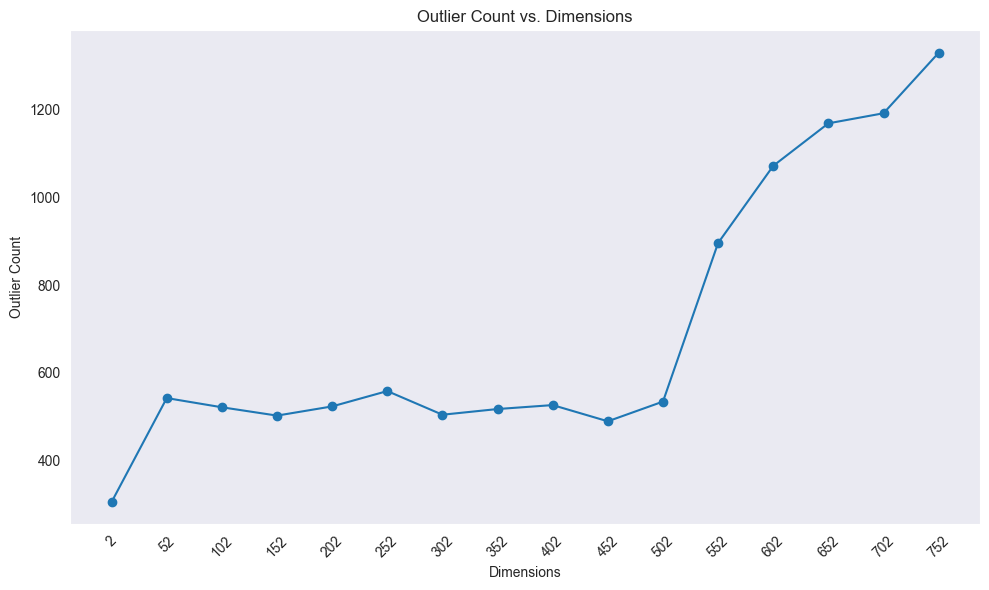

In [62]:
outlier_count, dimensions = dim_reduc_params_experiment()

In [ ]:
import matplotlib.pyplot as plt

# Visualize the relationship between dimensions and outlier count
plt.figure(figsize=(10, 6))
plt.plot(dimensions, outlier_count, marker='o')
plt.title('Outlier Count vs. Dimensions')
plt.xlabel('Dimensions')
plt.ylabel('Outlier Count')
plt.xticks(dimensions, rotation=45)
plt.grid()
plt.tight_layout()
plt.show()